<div class="alert alert-success">
    <h1 align="center">Lesson 2: Face Recognition (Siamese Network)</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

## Introduction

<h6>Face Recognition:</h6> 
 - Many classes, but very few examples for each class.

## Topics

- Face Recognition
- Siamese Network
- Contrastive loss and Triplet loss
- Defining and implementing a new Dataset class.

## Libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL.ImageOps   
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.utils
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

from data_utils import create_validation_data

use_gpu = torch.cuda.is_available()

Helper methods

In [2]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, mean, std, text=None, should_save=False):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)
    
    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)
    
    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

## Data

In [3]:
DATA_DIR = '/media/razavi/DATA/datasets/iranian_artist_cropped'
train_dir = f'{DATA_DIR}/train'
valid_dir = f'{DATA_DIR}/valid'

sz = 96
batch_size = 8
embed_size = 128
num_epochs = 200

cnn_name = 'resnet50'

In [4]:
# make validation dataset
if not os.path.exists(valid_dir):
    create_validation_data(train_dir, valid_dir, split=0.20, ext='jpg')

### Statistics

- Average width = `269.05`
- Average height = `334.98`
- Mean: `[0.5048, 0.4074, 0.3770]`
- Std:  `[0.2948, 0.2520, 0.2384]`

In [5]:
images = [f for f in glob(f'{train_dir}/*/*.jpg')]   # training images
images += [f for f in glob(f'{valid_dir}/*/*.jpg')]  # validation images

num_images = len(images)
avg_width, avg_height = 0.0, 0.0
for img_fname in tqdm(images, desc='Gathering statistics'):
    w, h = Image.open(img_fname).size
    avg_width += w
    avg_height += h
    
avg_width /= num_images
avg_height /= num_images

print('Average width: {:.2f}, Average height: {:.2f}'.format(avg_width, avg_height))

Gathering statistics: 100%|██████████| 130/130 [00:00<00:00, 1773.66it/s]

Average width: 267.62, Average height: 333.41


### Dataset

In many problems, we need to define our own Dataset class. To define a new Dataset, you should:
1. Create a subclass of `torch.utils.data.Dataset`
2. Override the following three methods:
 - The constructor or `__init__()`: this method is required to initialize the dataset object.
 - The `__getitem__()` method: this methos enables us to access each training data using its index. In other words, we can use the dataset as a simple list or sequence.
 - The `__len__()` method: this method returns number of data in the dataset.

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imgs, transform=None):
        """ Constructor
        Inputs:
            imgs: a list of images and their corresponding labels
            transform: required transformations
        """
        self.imgs = imgs
        self.transform = transform or transforms.ToTensor()
        
    def __getitem__(self, index):
        # select the image with given index from dataset
        anchor, anchor_label = self.imgs[index] 
        
        # we need to make sure approx 50% of images are in the same class
        is_negative = random.random() < 0.5
        if is_negative:
            second = random.choice([img for img, label in self.imgs if label != anchor_label])
        else:
            second = random.choice([img for img, label in self.imgs if label == anchor_label])
        
        # read pair of images
        anchor_img = Image.open(anchor).convert('RGB')
        second_img = Image.open(second).convert('RGB')
        
        # perform given transformations (if any)
        if self.transform is not None:
            anchor_img = self.transform(anchor_img)
            second_img = self.transform(second_img)
        
        return anchor_img, second_img, torch.Tensor([int(is_negative)])
    
    def __len__(self):
        return len(self.imgs)

#### Training data

In [7]:
zoom = int((1.0 + random.random() / 10.0) * sz)  # up to 10 percent zoom
stats = ([0.50480222, 0.4073655, 0.37700788], [0.29478898, 0.25199998, 0.2384155])

tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.RandomCrop(sz),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomGrayscale(0.2),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])


valid_tfms = transforms.Compose([
    transforms.Resize((zoom, zoom)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# training data
face_dataset = datasets.ImageFolder(train_dir)
train_ds = SiameseNetworkDataset(face_dataset.imgs, transform=tfms)
train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)

# validation data
valid_face_dataset = datasets.ImageFolder(valid_dir)
valid_ds = SiameseNetworkDataset(valid_face_dataset.imgs, transform=valid_tfms)
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

### Visualize dataset

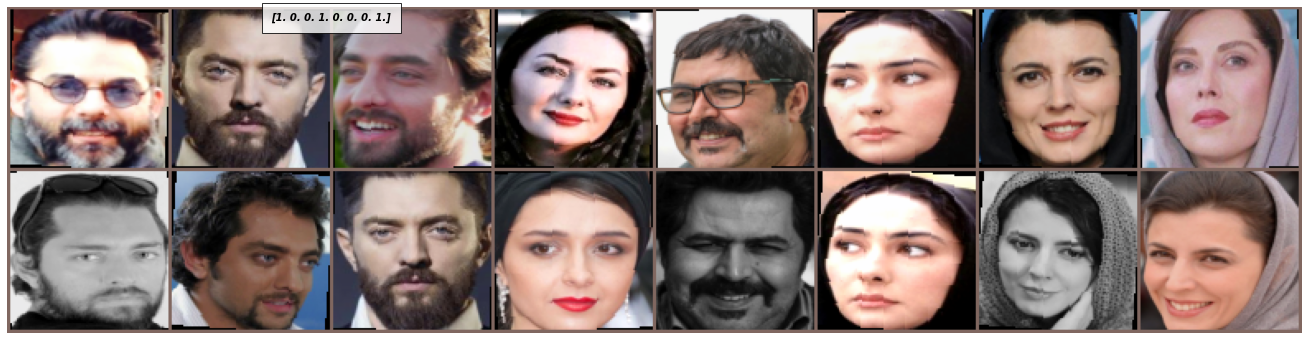

In [8]:
anchor_imgs, second_imgs, labels = next(iter(train_dl))
concat = torch.cat((anchor_imgs, second_imgs), 0)
labels = labels.numpy().T
plt.figure(figsize=(24, 6))
imshow(torchvision.utils.make_grid(concat, nrow=8),
       mean=stats[0], std=stats[1], text=f'{labels[0]}')

## Model: Siamese Netwok

In [9]:
class SiameseNetwork(nn.Module):
    
    def __init__(self, cnn, embed_size=128):
        super(SiameseNetwork, self).__init__()
        
        num_features = cnn.fc.in_features
        cnn.fc = nn.Linear(num_features, embed_size) 
        self.cnn = cnn

    def forward(self, x1, x2):
        f1 = self.cnn(x1)
        f2 = self.cnn(x2)
        return f1, f2

## Loss: Contrastive Loss

Given a pair of images and the corresponding label (0 or 1), the contrastive loss is defined as:
- if $y = 0$:
$$\lVert f(a) - f(b) \rVert^2$$
- if $y = 1$:
$$\max (\alpha - \lVert f(a) - f(b) \rVert, 0)^2$$

In [10]:
class ContrastiveLoss(nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss,self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive

## Train

In [11]:
def train_step(model, train_dl, criterion, optimizer, device):
    model.train()
    
    N = len(train_dl.dataset)
    steps = N // train_dl.batch_size
    avg_loss = 0.0
    for i, (imgs0, imgs1, lbls) in enumerate(train_dl):
        imgs0, imgs1, lbls = imgs0.to(device), imgs1.to(device), lbls.to(device)
        
        # forward
        features0, features1 = model(imgs0, imgs1)
        
        # loss
        loss = criterion(features0, features1, lbls)
        avg_loss = (avg_loss * i + loss.item()) / (i + 1)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # report
        sys.stdout.flush()
        sys.stdout.write("\r Training Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()

    return model, avg_loss    


def validate_step(model, valid_dl, criterion, device):
    model.eval()
    
    N = len(valid_dl.dataset)
    steps = N // valid_dl.batch_size
    avg_loss = 0.0

    with torch.no_grad():
        for i, (imgs0, imgs1, lbls) in enumerate(valid_dl):
            imgs0, imgs1, lbls = imgs0.to(device), imgs1.to(device), lbls.to(device)

            features0, features1 = model(imgs0, imgs1)
            loss = criterion(features0, features1, lbls)
            avg_loss = (avg_loss * i + loss.item()) / (i + 1)

            # report
            sys.stdout.flush()
            sys.stdout.write("\r Validation Step [{}/{}]: loss {:.5f}  ".format(i+1, steps+1, avg_loss))
    print()
    
    return avg_loss


def train(model, train_dl, valid_dl, criterion, optimizer, device, scheduler=None, num_epochs=10):
    best_loss = float('inf')
    best_weights = model.state_dict().copy()
    
    train_loss_history, valid_loss_history = [], []
    
    for epoch in range(num_epochs):
        
        print(f'Epoch {epoch + 1}\n--------')
        
        model, train_loss = train_step(model, train_dl, criterion, optimizer, device)
        valid_loss = validate_step(model, valid_dl, criterion, device)
        if scheduler:
            scheduler.step()
        
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_weights = model.state_dict().copy()
            torch.save(best_weights, f'tmp/{cnn_name}-facereco-iranians-{epoch}-{best_loss}.pth')
        print()
        
    loss_history = (train_loss_history, valid_loss_history)
    model.load_state_dict(best_weights)
    return model, loss_history

In [12]:
# training and validation data
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# model
cnn = get_model(cnn_name)
model = SiameseNetwork(cnn, embed_size)
model = model.to(device)

# loss and optimizer
criterion = ContrastiveLoss()
criterion = criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0002)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [13]:
model

SiameseNetwork(
  (cnn): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [14]:
model, loss_hist = train(model, 
                         train_dl, 
                         valid_dl, 
                         criterion, 
                         optimizer, 
                         device,
                         scheduler, 
                         num_epochs=50)

Epoch 1
--------
 Training Step [1/13]: loss 7.64803  

/home/razavi/Documents/mygithub/DeepLearning/Deep_Learning_in_Python_2018/venv/lib/python3.6/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


 Training Step [13/13]: loss 5.99305  
 Validation Step [4/5]: loss 1.43343  

Epoch 2
--------
 Training Step [13/13]: loss 3.98479  
 Validation Step [4/5]: loss 2.40229  

Epoch 3
--------
 Training Step [13/13]: loss 3.35189  
 Validation Step [4/5]: loss 1.81281  

Epoch 4
--------
 Training Step [13/13]: loss 2.93174  
 Validation Step [4/5]: loss 2.34039  

Epoch 5
--------
 Training Step [13/13]: loss 2.63862  
 Validation Step [4/5]: loss 1.81654  

Epoch 6
--------
 Training Step [13/13]: loss 3.10247  
 Validation Step [4/5]: loss 1.46579  

Epoch 7
--------
 Training Step [13/13]: loss 2.14551  
 Validation Step [4/5]: loss 1.39823  

Epoch 8
--------
 Training Step [13/13]: loss 1.79479  
 Validation Step [4/5]: loss 1.29886  

Epoch 9
--------
 Training Step [13/13]: loss 2.12344  
 Validation Step [4/5]: loss 1.44851  

Epoch 10
--------
 Training Step [13/13]: loss 1.64196  
 Validation Step [4/5]: loss 1.16618  

Epoch 11
--------
 Training Step [13/13]: loss 1.62384  

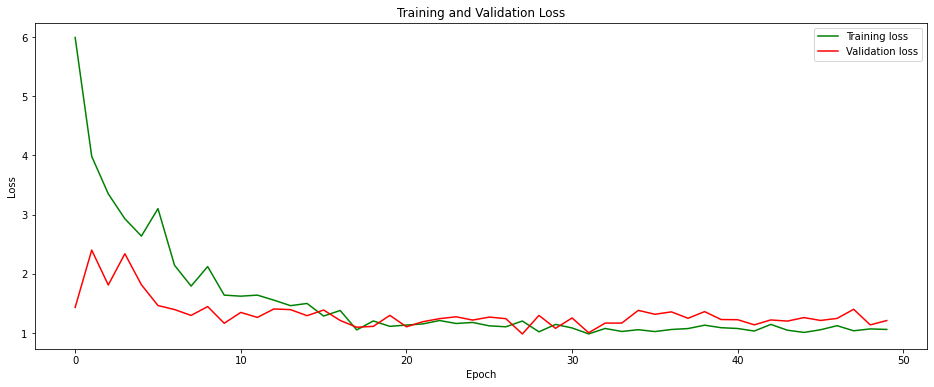

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(loss_hist[0], 'g', label='Training loss')
plt.plot(loss_hist[1], 'r', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

## Testing

In [16]:
valid_dl = DataLoader(valid_ds, batch_size=1, shuffle=False)

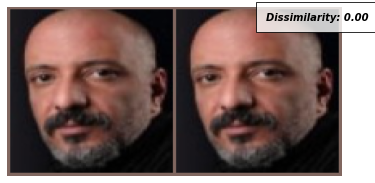

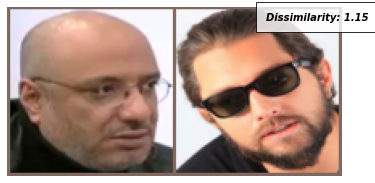

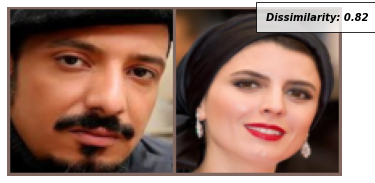

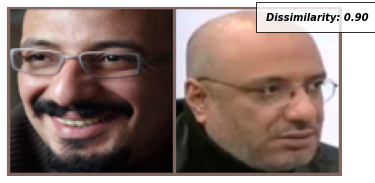

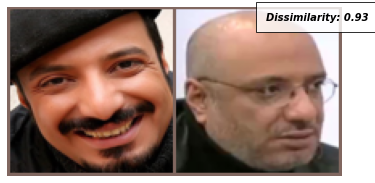

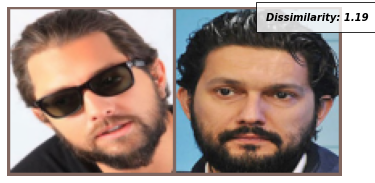

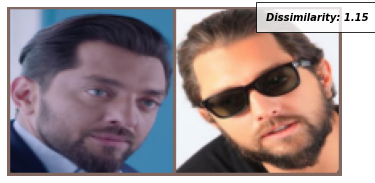

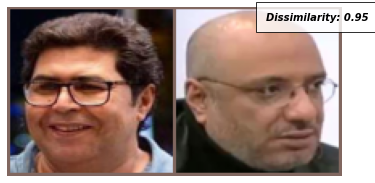

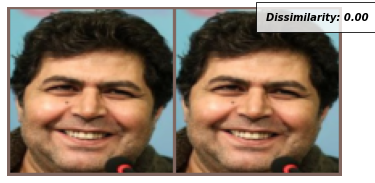

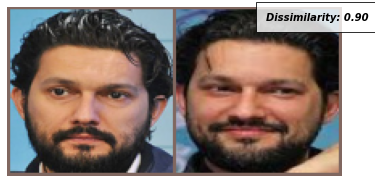

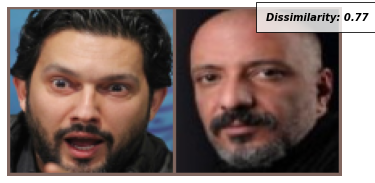

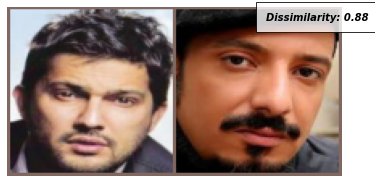

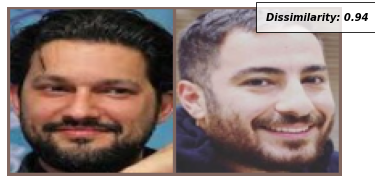

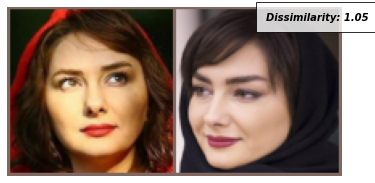

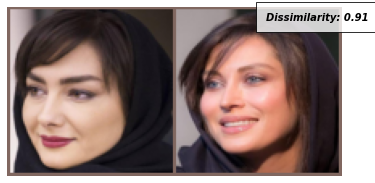

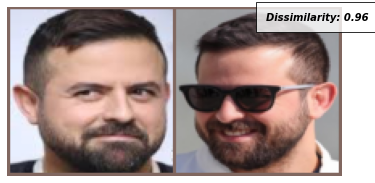

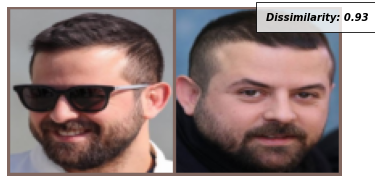

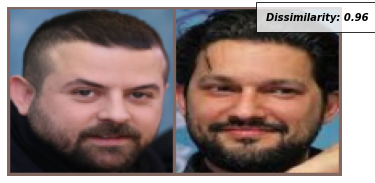

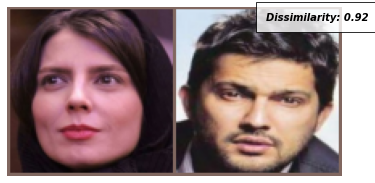

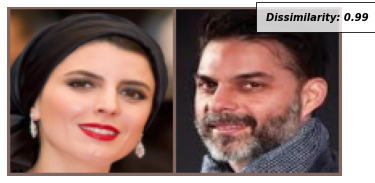

In [17]:
model.eval()

dataiter = iter(valid_dl)

with torch.no_grad():
    for i in range(20):
        x0, x1, _ = next(dataiter)
        concat = torch.cat((x0, x1), 0)
        x0, x1 = x0.to(device), x1.to(device)
        f0, f1 = model(x0, x1)
        euclidean_distance = F.pairwise_distance(f0, f1)
        imshow(torchvision.utils.make_grid(concat),
               mean=stats[0], std=stats[1],
               text=f'Dissimilarity: {euclidean_distance.item():.2f}')